In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [15]:
df_btc = pd.read_feather('../data/df_btc_with_features_5m_spot.feather')
df_btc = df_btc.sort_values(by = ['open_time'], ignore_index = True)

In [16]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")

# applying to X results in hierarchical data
df_btc['close_box'] = boxcox_trafo.fit_transform(df_btc['close'])
df_btc['ret'] = df_btc['close'].pct_change(1)

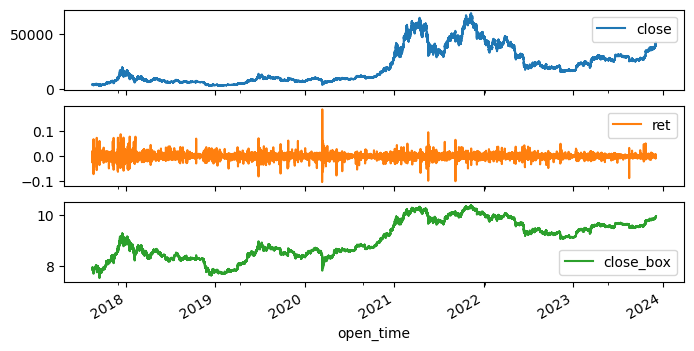

In [17]:
ax = df_btc.plot(x = 'open_time', y = ['close', 'ret', 'close_box'], subplots = True, sharex = True, figsize = (8, 4))

In [18]:
window = 30
file = f'mean_corr.csv'
corr = pd.read_csv(f'../output/feature_corr/target_30m_feature.csv', header = 0, index_col = 0)

In [19]:
features = corr.index.tolist()[:50]
# features += ['close','volume', 'open_time', 'token', 'ret']
features = ['token', 'ret', 'open_time']
X = df_btc[features].replace([-np.inf, np.inf], np.nan).fillna(0)

In [20]:
test = X['ret']

In [ ]:
from tsfresh import extract_relevant_features, extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters


features_filtered_direct = extract_features(X, column_id="token", column_sort="open_time", column_kind=None, column_value=None, default_fc_parameters = ComprehensiveFCParameters())

python(7433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]